In [25]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs


def linear_force_kernel_antiplane(xo, yo, xf, yf, w, mu):
    # Compute displacement and stress kernels for a linearly varying force on a
    # horizontal source element (-w <= x <= w, y = 0)
    #
    # INPUTS
    # xo, yo - observation locations provided as individual vectors [Nobs x 1]
    # xf, yf - source element center location (scalars)
    # w - source element half-length
    # mu - Elastic parameters
    #
    # OUTPUTS
    # Disp - 2-d displacement kernels [Nobs x 2 basis functions]
    # Stress - 3-d stress_kernels     [Nobs x (sx or sy) x 2 basis functions]
    #
    # AUTHORS
    # Rishav Mallick, JPL, 2024

    n_obs = len(xo)
    x = xo - xf
    y = yo - yf

    u_1 = (
        (1 / 16)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w * (2 * w + x)
            + 4 * (w + x) * y * np.arctan2(w - x, y)
            + 4 * (w + x) * y * np.arctan2(w + x, y)
            + ((w + (-1) * x) * (3 * w + x) + y**2) * np.log((w + (-1) * x) ** 2 + y**2)
            + (w + x + (-1) * y) * (w + x + y) * np.log((w + x) ** 2 + y**2)
        )
    )

    u_2 = (
        (1 / 16)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            4 * w * ((-2) * w + x)
            + 4 * (w + (-1) * x) * y * np.arctan2(w - x, y)
            + 4 * (w + (-1) * x) * y * np.arctan2(w + x, y)
            + (w + (-1) * x + (-1) * y)
            * (w + (-1) * x + y)
            * np.log((w + (-1) * x) ** 2 + y**2)
            + ((3 * w + (-1) * x) * (w + x) + y**2) * np.log((w + x) ** 2 + y**2)
        )
    )

    ex_1 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w
            + 2 * y * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + (-1) * (w + x) * np.log((w + (-1) * x) ** 2 + y**2)
            + (w + x) * np.log((w + x) ** 2 + y**2)
        )
    )

    ex_2 = (
        (-1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w
            + 2 * y * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + (w + (-1) * x)
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ey_1 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            2 * (w + x) * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + y
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ey_2 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            2 * (w + (-1) * x) * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + y
            * ((-1) * np.log((w + (-1) * x) ** 2 + y**2) + np.log((w + x) ** 2 + y**2))
        )
    )

    # Store displacement kernels (2-d matrix), [Nobs x 2 basis functions]
    disp = np.hstack((u_1, u_2))

    # Store stress kernels (3-d matrix), [Nobs x (sx or sy) x 2 basis functions]
    stress = np.zeros((n_obs, 2, 2))
    stress[:, 0, :] = np.hstack((mu * ex_1, mu * ex_2))
    stress[:, 1, :] = np.hstack((mu * ey_1, mu * ey_2))

    return disp, stress

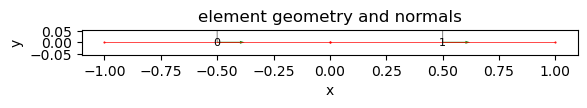

In [26]:
mu = 1.0
els = bemcs.initialize_els()

# setup a fault geometry
els.x1 = np.array([-1.0, 0.0])
els.y1 = np.array([0.0, 0.0])
els.x2 = np.array([0.0, 1.0])
els.y2 = np.array([0.0, -0.0])

bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

In [27]:
# # Observation points
# xo = np.linspace(-2, 2, 100).reshape(-1, 1)
# yo = np.zeros_like(xo) + 1e-6

nx_obs = 100
ny_obs = 100
x_obs = np.linspace(-2, 2, nx_obs)
y_obs = np.linspace(-2, 2, ny_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
xo = x_obs.flatten().reshape(-1, 1)
yo = y_obs.flatten().reshape(-1, 1)

K_sx, K_sy, K_u = bemcs.get_displacement_stress_kernel_slip_antiplane(xo, yo, els, mu)

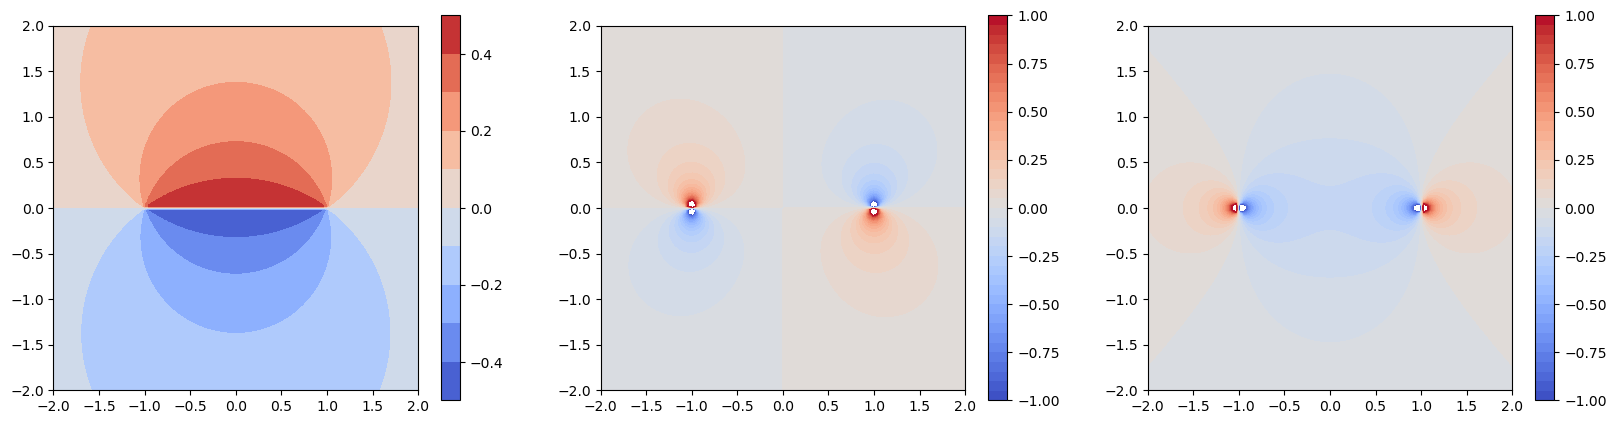

In [33]:
quadcoefs = np.array([1, 1, 1, 1, 1, 1]).reshape(-1, 1)
u = K_u @ quadcoefs
sx = K_sx @ quadcoefs
sy = K_sy @ quadcoefs

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
toplot = u.reshape(ny_obs, nx_obs)
maxval = 0.5
minval = -maxval
levels = np.linspace(minval, maxval, 11)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 2)
toplot = sx.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 41)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")

plt.subplot(1, 3, 3)
toplot = sy.reshape(ny_obs, nx_obs)
maxval = 1
minval = -maxval
levels = np.linspace(minval, maxval, 41)
plt.contourf(
    xo.reshape(ny_obs, nx_obs),
    yo.reshape(ny_obs, nx_obs),
    toplot,
    cmap="coolwarm",
    vmin=minval,
    vmax=maxval,
    levels=levels,
)
plt.colorbar()
plt.gca().set_aspect("equal", adjustable="box")
plt.show()